## Iterative QPE
- This is a class implementing the iterative quantum phase estimation algorithm which uses a single ancillary qubit in our phase estimation procedure
- This is a generic class which is used to implement single as well as multi qubit phase estimation


In [34]:
from qiskit import *
from qiskit import transpile 
from qiskit.tools.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor 
from qiskit.extensions import UnitaryGate
from qiskit.circuit import Gate 
from qiskit import IBMQ 

%matplotlib inline

ibmqfactory.load_account:WARNING:2021-06-15 14:41:11,923: Credentials are already in use. The existing account in the session will be replaced.


### Execute cell for actual backend testing

In [35]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2021-06-15 14:41:57,904: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
qiskit.__qiskit_version__

In [28]:
class IQPE():
    '''Implements the iterative QPE algorithm upto n bit precision specified by user 
    
    Attributes:
        precision : int([1,...]): precision of the phase estimation ( also equal to number of qubits in scratch register)
        unitary(np.ndarray or QuantumCircuit or UnitaryGate): unitary operator for which QPE is being applied.
        unknown(bool) : a boolean variable used to specify whether exponentiation of unitary needs to be done or not 
                        (True : no exponentiation done) 
        powers(dict): contains the powers of the unitary matrix
                      key : exponent, value : U^(exponent)
        controls(dict): contains equivalent controlled U gates to be applied
                      key : iteration number, value : controlled U gate
                      
    Methods : 
        get_powers(unitary,n) : generates powers of U from U^1 -> U^(2^(n-1)) and stores power in dict 
        get_controls() : generates the U^(2^j) control gates for faster simulation of the QPE algorithm
        
    '''
    def __init__(self, precision, unitary, unknown=False):  # write docs
        '''
        Args :
            precision(int) : The precision upto which the phase needs to be estimated.
                             Interpreted as 2^(-precision).
                             eg. precision = 4 means the phase is going to be precise
                                 upto 2^(-4).
            unitary(np.ndarray or UnitaryGate or QuantumCircuit):
                            The unitary for which we want to determine the phase. Currently
                            this class supports 2 x 2 matrices or single qubit gates.
                            Shall be extended for higher order matrices.
            unknown(bool) : Whether exponentiation is to be done or not 
        Raises :
            TypeError : if precision or unitary are not of a valid type
            ValueError : if precision is not valid
            Exception : if unitary is of larger size than 2 x 2

        Examples :
            from iter_QPE import IQPE
                # passing as ndarray
                theta = 1/5
                U1 = np.ndarray([[1,0],
                                [0, np.exp(2*np.pi*1j*(theta))]])
                                
                qpe1 = IQPE(precision = 4, unitary = U1,unknown = True)

                # passing as QuantumCircuit
                U2 = QuantumCircuit(1)
                U2.rz(np.pi/7,0)
                qpe2 = IQPE(precision = 5,unitary = U2,unknown = True)

        '''
        # handle precision
        if type(precision) != int:
            raise TypeError("Precision needs to be an integer")
        elif precision < 0 or precision == 0:
            raise ValueError("Precision needs to be atleast 1")

        self.precision = precision

        # handle unitary
        if not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit)\
                and not isinstance(unitary, UnitaryGate) and not isinstance(unitary,Gate):
            raise TypeError("A numpy array, Quantum Circuit or Gate needs to be passed as the unitary matrix")
    
        if unknown == False:
            # means matrix rep needed 
            if not isinstance(unitary,np.ndarray) and not isinstance(unitary,UnitaryGate):
                raise TypeError('''Unitary needs to be of type ndarray or Unitary Gate if optimization  
                                needs to be done''')
            if isinstance(unitary, UnitaryGate):
                U = unitary.to_matrix()
            else:
                U = unitary # already an array 
        else:
            # if it is numpy type array 
            if isinstance(unitary,np.ndarray):
                U = UnitaryGate(data = unitary)
            else:
                U = unitary 
            # here we can directly use the .control method in our circuit.
            
            
        # the unitary is an ndarray if unknown is False and 
        # the unitary is not ndarray is unknown is true 
        self.unitary = U
        self.unknown = unknown
        self.powers = {}
        
        # optimization can only be performed when we know the 
        # matrix representation 
        if unknown == False:
            self.controls = self.get_controls()

    def get_powers(self, unitary, n):
        '''This function returns the matrix U^(n) and saves 
           other smaller powers 
            
        Arguments: 
            unitary(np.ndarray): 
                The Unitary matrix which needs to be exponentitated 
            n(int): integer specifying the exponent 
            
        Raises:
            ValueError : when n is < 0 
        Returns: 
            a dictionary containing the relevant powers of the matrix U '''
        if n < 0:
            raise ValueError("Power should be atleast 0")
        if n == 1:
            self.powers[1] = unitary
            return unitary
        if n % 2 == 1:
            if n-1 not in self.powers:
                self.powers[n-1] = self.get_powers(unitary, n-1)
                
            self.powers[n] = unitary @ self.powers[n-1]
            return self.powers[n]
        else:
            if n/2 not in self.powers:
                self.powers[n/2] = self.get_powers(unitary, n/2)

            self.powers[n] = self.powers[n/2] @ self.powers[n/2]
            return self.powers[n]
    
    # get the controls, if using optimization
    def get_controls(self):
        '''Get the control gates for the circuit
         While computing exponent, we also 
         compute the smaller powers
         
        Returns: 
            controls(dict) : dictionary containing the relevant controlled unitary gates
                            key : iteration number, value : controlled U gate 
             '''
             
        n_iters = self.precision

        exp = 2**(n_iters-1)
        self.get_powers(self.unitary, exp)

        # got the powers
        controls = {}
        
        # note that iteration 0 has the highest powered matrix and
        # then it goes on to get lesser and lesser
        iterations = self.precision
        for it in range(iterations):
            mat = self.powers[exp]
            u_gate = UnitaryGate(data=mat)
            cu = u_gate.control(num_ctrl_qubits=1, label='CU', ctrl_state='1')
            controls[it] = cu
            exp /= 2

        return controls

    def get_circuit_phase(self, QC, clbits, qubits, ancilla, show=False,backend = None,
                          save_circ = False, circ_name = "IQPE_circ.JPG"):
        # QC must be atleast size 2
        '''Add the experiments pararmeters .., and the shots parameter '''
        
        '''
        Returns the circuit phase as a 2-tuple phase : (binary phase,decimal phase)
        Arguments: 
            QC(QuantumCircuit) : the circuit containing the eigenvector of the unitary matrix 
            clbits(list-like) : the list of the classical bits in which the phase would be saved 
            qubits(list-like) : the indices of the qubits containing the eigenvector of unitary
            ancilla(int) : the ancilliary qubit which would be used as the control qubit   
            show(bool) : boolean to specify if circuit should be drawn or not 
            save(bool) : boolean to specify if circuit should be saved or not 
                    (saved as IQPE_circuit.JPG, if true) 
            backend(IBMQBackend) : backend for running the circuit 
                    NOTE : IBMQ provider must be enabled for execution of circuits on real backends

            
        Raises: 
            ValueError : if clbits are not equal to precision or non-unique bits specified 
                         or if elements of clbits/qubits are not integer type or ancilla qubit is 
                         same as one of the eigenvector qubits
            TypeError : if qubit indices are not integral 
            Exception : if unitary has less than 2 qubits  
            
        
        Returns : 
            A 2-tuple specifying the phase of unitary matrix : (binary phase,decimal phase) 
        
        Usage Notes : 
        NOTE : The phase is assumed to be a binary fraction as 0.x1x2x2...xn where n  
               is the precision specified by the user.
               
               The least significant bit , xn, is saved in the qubit with index 
               precision-1 and the most significant bit, x1, is saved in the 
               qubit with index 0 in the phase[0] of tuple. 
               
        For example :- 
            theta = 1/5  # binary representation upto 4 bits : 0.0011
            unitary = np.ndarray([[1,0],
                                [0, np.exp(2*np.pi*1j*(theta))]])
            q = QuantumCircuit(6,4)
            q.x(4) # the eigenvector qubit

            qpe = get_circuit_phase(precision = 4,unitary = unitary,unknown = True)
            athens = provider.get_backend('ibmq_athens')
            phase = iqpe.get_circuit_phase(
            QC=q, clbits=[0, 1, 2, 3], qubits=[4], ancilla=3, show=True,backend = athens)
            
            # phase[0] would contain a 4-bit phase representation 
            # phase[1] would contain the decimal representation of the phase
        '''
        
        # handle qubits in circuit
        if len(QC.qubits) < 2:
            raise Exception("Quantum Circuit needs to have atleast size 2")

        # handle classical bits
        if len(clbits) != self.precision:
            raise ValueError("Exactly",self.precision,"classical bits needed for measurement")
        elif len(set(clbits)) != len(clbits):
            raise ValueError("Non-unique classical bits given for measurement")
        elif not all(isinstance(i, int) for i in clbits):
            raise ValueError("All classical indices must be integer type")

            
        # qubit and ancilla need to be integers
        if type(ancilla) is not int:
            raise TypeError("Ancilla indix need to be specified as integer")
        elif not all(isinstance(i,int) for i in qubits):
            raise TypeError("The indices containing the eigenvector must be integer type ")
        elif len(set(qubits)) != len(qubits):
            raise ValueError("Non-unique qubits given for the eigenvector")
        elif ancilla in qubits:
            raise Exception("Ancilla can not be equal to a qubit index ")
            
        res = []
        # start with the iteration
        phase = -2*np.pi
        factor = 0
        iterations = self.precision
        # generate the qubit list on which the Unitary is applied
        qargs = [ancilla]
        for q in qubits:
            qargs.append(q) 
        
        if self.unknown == True:
            # no matrix repr is available -> means .control method can be applied easily
            exponent = 2**(iterations - 1)
            CU = self.unitary.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state=1)
        
        for it in range(iterations):
            # start
            QC.reset(ancilla)
            QC.h(ancilla)
            # add the inverse rotation
            inv_phase = phase*factor

            QC.p(inv_phase, ancilla)

            # add the controlled Unitary of iteration it 
            if self.unknown == False:
                QC = QC.compose(self.controls[it], qubits=qargs)
            else:
                # need to add exponential amount of matrices 
                for _ in range(int(exponent)):
                    QC = QC.compose(CU,qubits = qargs)
                exponent /= 2 
                
            # add H gate
            QC.h(ancilla)
            QC.measure(ancilla, clbits[it])

            # or, iterate in reverse manner , no of steps ->
            # clbits[it] as it is the absolute
            # classical register index
            if backend == None: # simulating 
                counts = execute(QC, backend=Aer.get_backend('qasm_simulator'), shots=1).result().get_counts()
            else:
#                 trans = transpile(QC,backend = backend,optimization_level = 3)
                job = execute(QC,shots = 1,backend = backend,job_name = "Iter "+str(it+1),
                             optimization_level = 3)
#                 print("DEPTH ",trans.depth())
                display(job_monitor(job))
                counts = job.result().get_counts()
                    
            # we will have only one single key in the dict
            key = list(counts.keys())[0][::-1]
            # try adding x based on clasical
            curr_bit = key[clbits[it]]
            res.append(int(curr_bit))
            # if bit measured is 1
            if curr_bit == '1':
                factor += 1/2  # add the phase factor

            factor = factor/2  # shift each towards one weight right
            if it+1 == iterations:
                if show == True:
                    if save_circ == False:
                        display(QC.draw('mpl'))
                    else:
                        display(QC.draw(output='mpl',filename = circ_name,scale = 0.8))

        # phase has now been stored in the clbits
        # returning its binary representation

        # need to reverse as LSB is stored at the zeroth index and
        # not the last
        res = res[::-1]
        
        #find decimal phase 
        dec = 0
        weight = 1/2
        for k in res:
            dec += (weight)*k
            weight /= 2
            
        return (res,dec)

## Testing Circuit with phase 0.2
- Made a unitary with phase 0.2 to test the circuit
- 4 iterations were used to determine the final phase

In [14]:
U = UnitaryGate(data=np.array([[1, 0],
                               [0, np.exp(2*np.pi*1j*(1/5))]]))

In [15]:
iqpe = IQPE(precision=4,unitary=U,unknown=True) 

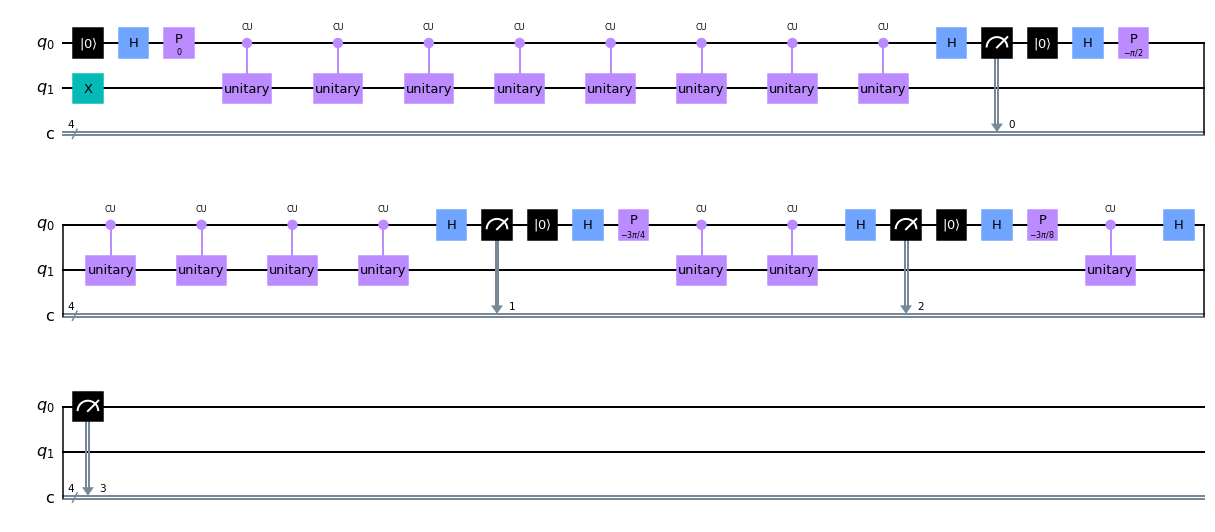

In [17]:
q = QuantumCircuit(2, 4)
q.x(1)
phase = iqpe.get_circuit_phase(
    QC=q, clbits=[0, 1, 2, 3], qubits=[1],ancilla=0, show=True, save = True)

In [18]:
phase 

([0, 0, 1, 1], 0.1875)

## Testing with multi qubit unitary
- Made a unitary with a controlled application of Phase gate over the target qubit
- 7 iterations were used to determine this multiqubit phase(1/6) 

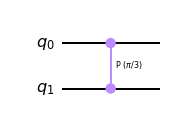

In [29]:
U = QuantumCircuit(2,name='U')
U.cp(2*np.pi*1/6,0,1)
U.draw('mpl')
#.control(num_ctrl_qcubits= 1, label = 'CCu', ctrl_state = '1')

In [30]:
iqpe = IQPE(precision=4,unitary=U,unknown=True) 

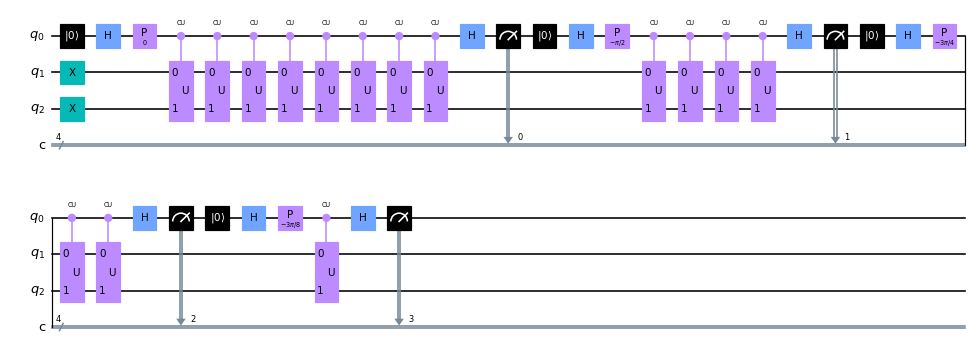

In [31]:
q = QuantumCircuit(3, 4)
q.x(1)
q.x(2)
phase = iqpe.get_circuit_phase(
    QC=q, clbits=[0, 1, 2, 3], qubits=[1,2],ancilla=0, show=True,save_circ = True,circ_name = "IQPE_circ.JPG")

In [32]:
print("Phase of the circuit in binary:", phase)


Phase of the circuit in binary: ([0, 0, 1, 1], 0.1875)


## Testing the circuit for increasing precision
- Using a 3 qubit matrix to test out the circuit 

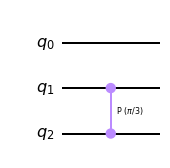

In [128]:
u2 = QuantumCircuit(3)
u2.cp(2*np.pi*(1/6),1,2)
u2.draw('mpl')

- The phase of this circuit would be **1/6** i.e. ~ **0.16667** given that the qubits are prepared in the eigenvector state which is **|110>** acc to qiskit notation

In [133]:
estimates = []
for prec in range(2, 9):
    q = QuantumCircuit(4, prec)
    # making eigenvector 
    q.x(2)
    q.x(3)
    iqpe = IQPE(precision=prec, unitary=u2,unknown=True)
    phase = iqpe.get_circuit_phase(
        QC=q, clbits=[i for i in range(prec)], qubits=[1,2,3], ancilla=0)
#     print(phase[0])
    estimates.append(phase[1])

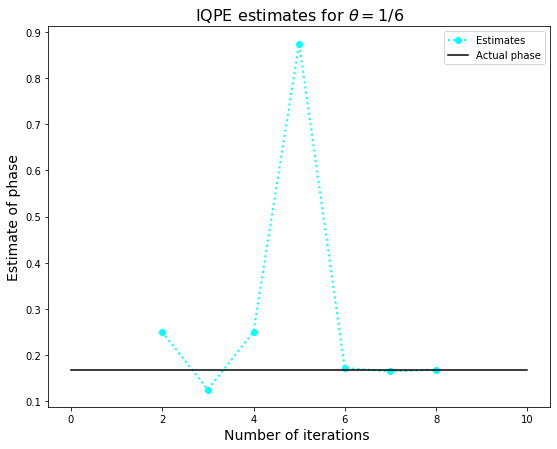

In [135]:
plt.figure(figsize=(9, 7))
plt.plot(list(range(2, 9)), estimates, marker='o',
         label='Estimates', linestyle='dotted',linewidth = 2,color = 'cyan')
plt.plot([0, 10], [0.16667, 0.16667], color='black', label='Actual phase')
plt.title("IQPE estimates for $\\theta = 1/6$", fontsize=16)
plt.xlabel("Number of iterations ", fontsize=14)
plt.ylabel("Estimate of phase", fontsize=14)
plt.legend()

### Making a generic Function
- This is a simple generic function used for making a plot of how the circuit converges to the phase for a given theta value for single qubit phase gates.
- Note that **unknown == True** is actually important for realizing the true simulation. 


In [36]:
def get_estimate_plot_phase(theta = None,unitary = None,unknown = True, experiments = 1,iters=9, show_circ=False, save=False,
                      backend = None):
    '''
    Displays an estimate plot of the phase that is found through the IQPE 
    algorithm for single qubit phase unitaries
    
    theta(float) : contains the actual theta (if some theoretical assumption is known)
    unitary(ndarray / QuantumCircuit / UnitaryGate) :
                  the unitary for which phase needs to be determined 
    unknown(bool) : boolean variable to specify whether the optimization in unitary 
                    application is to be used 
    experiments(int) : the number of experiments for which each iteration is to be run
    iters(int) : the max number of iterations to be run ( circuit is run from precision 
                2 -> iters)
                
    show_circ(bool) : boolean variable to specify whether circuit needs to be drawn or not 
    save(bool) : boolean variable specifying whether plot needs to be saved or 
                 not (saved as IQPE Plots/Estimate_plot_theta.jpg)

    backend(IBMBackend) : ibmq backend on which the circuit should be run (if None, 
                    qasm_simulator is used)
                    
    Example :- 
        provider = IBMQ.get_provider('ibm-q')
        casb = provider.get_backend('ibmq-casablanca)
        U = np.array([[1,0],
                     [0, np.exp(2*np.pi*1j(0.524))]])
                     
        get_estimate_plot(unitary = U, iters = 10,unknown= True, save=True,backend = casb)

    '''
    import os
    if theta is None and unitary is None:
        raise Exception("Atleast one of theta or unitary is needed.")
        
    if theta > 1 or theta < 0:
        raise ValueError(
            "Theta must be specified as a float val between 0 and 1")

    if unitary is None:
        unitary = np.array([[1, 0],
                            [0, np.exp(2*np.pi*1j*(theta))]])

    estimates, errors = [], []
    avg_phase, avg_error = {},{}
    for prec in range(2, iters):
        print("\n\nITERATION NUMBER", prec-1, "...\n\n")
        
        iqpe = IQPE(precision=prec, unitary=unitary,unknown = unknown )
        dec_phase,abs_errors = [],[]
        
        for exp in range(experiments):
            # single qubit rotation matrices 
            q = QuantumCircuit(2, prec)
            q.x(1)
            # simulate the matrix on a circuit 
            phase = iqpe.get_circuit_phase(
                QC=q, clbits=[i for i in range(prec)], qubits=[1], ancilla=0, show=show_circ,
                backend = backend)
            # add the phase and the error ...
            dec_phase.append(phase[1])
            print("Binary Phase in experiment",exp, phase[0])

            if theta is not None:
                ae = np.round(abs(phase[1]-theta),5)
                abs_errors.append(ae)
                
        # run experiments number of times AND get the avg phase 
        
        avg_phase[prec] = sum(dec_phase)/len(dec_phase)
        avg_error[prec] = sum(abs_errors)/len(abs_errors)
                 
        print("Decimal Phase :", avg_phase[prec])
        print("Absolute Error :",avg_error[prec])
        if theta is not None:
            print("Percentage error :",avg_error[prec]*100/theta,"%")
        
        # append to graph 
        estimates.append(avg_phase[prec])
        errors.append(avg_error[prec])
    
    # choose color
    colors = ['r', 'g', 'c', 'm', 'y']
    c1 = np.random.choice(colors)[0]
    c2 = np.random.choice(colors)[0]
    while c2 == c1:
        c2 = np.random.choice(colors)[0]
    plt.figure(figsize=(9, 7))
    plt.grid(True)
    
    # plot 
    plt.plot([i for i in range(2, iters)], estimates, alpha=0.6, marker='o',
             color=c1, label='Estimates', linestyle='dashed', linewidth=2)
    plt.plot([i for i in range(2, iters)], errors, alpha=0.6, marker='s',
             color=c2, label='Absoulte error', linestyle='dotted', linewidth=2)
    if theta != None:
        plt.plot([0, iters], [theta, theta], color='black', label='Actual phase')
    plt.title("IQPE estimates for $\\theta ="+str(theta)+"$", fontsize=16)
    plt.xlabel("Number of iterations ", fontsize=14)
    plt.ylabel("Estimates by IQPE", fontsize=14)
    plt.legend()
    if save:
        os.makedirs("IQPE Plots", exist_ok=True)
        plt.savefig("IQPE Plots/Estimate_plot_"+str(theta)+".jpg", dpi=200)

- Testing for actual backend **ibmq-casablanca**

In [40]:
casb = provider.get_backend('ibmq_casablanca')



ITERATION NUMBER 1 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [1, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [1, 0]
Decimal Phase : 0.45
Absolute Error : 0.16440000000000002
Percentage error : 31.37404580152672 %


ITERATION NUMBER 2 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [1, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [1, 1, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [1, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [1, 1, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [1, 0, 0]
Decimal Phase : 0.65
Absolute Error : 0.1548
Percentage error : 29.541984732824424 %


ITERATION NUMBER 3 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [1, 0, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [1, 0, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [1, 0, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [1, 0, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [1, 0, 1, 0]
Decimal Phase : 0.5375
Absolute Error : 0.0423
Percentage error : 8.072519083969464 %


ITERATION NUMBER 4 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [0, 0, 0, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [1, 1, 0, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [0, 0, 0, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [0, 1, 0, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [0, 1, 1, 1, 0]
Decimal Phase : 0.3125
Absolute Error : 0.3269
Percentage error : 62.385496183206115 %


ITERATION NUMBER 5 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [0, 0, 0, 0, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [0, 0, 0, 0, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [1, 1, 0, 0, 1, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [0, 0, 0, 0, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [1, 1, 1, 0, 0, 1]
Decimal Phase : 0.353125
Absolute Error : 0.42667400000000005
Percentage error : 81.42633587786261 %


ITERATION NUMBER 6 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [1, 0, 1, 1, 1, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [0, 1, 1, 1, 0, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [0, 0, 0, 0, 1, 0, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [0, 0, 0, 1, 0, 1, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [0, 0, 0, 0, 0, 0, 0]
Decimal Phase : 0.2609375
Absolute Error : 0.347212
Percentage error : 66.2618320610687 %


ITERATION NUMBER 7 ...


Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 0 [1, 1, 1, 1, 1, 0, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 1 [0, 0, 1, 1, 1, 1, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 2 [1, 1, 0, 0, 1, 1, 0, 1]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 3 [1, 1, 1, 0, 1, 1, 1, 0]
Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Job Status: job has successfully run


None

Binary Phase in experiment 4 [0, 0, 0, 0, 1, 0, 0, 0]
Decimal Phase : 0.59453125
Absolute Error : 0.38192000000000004
Percentage error : 72.88549618320612 %


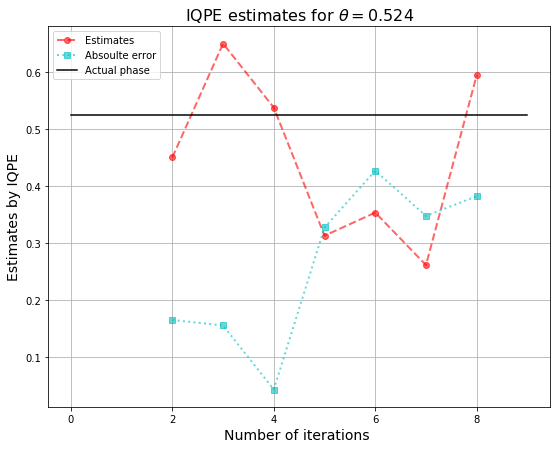

In [28]:
get_estimate_plot_phase(theta=0.524, iters = 9,unknown= True, save=True, experiments=5,backend=casb)

- Testing for simulator



ITERATION NUMBER 1 ...


Binary Phase in experiment 0 [0, 1]
Binary Phase in experiment 1 [0, 1]
Binary Phase in experiment 2 [0, 1]
Binary Phase in experiment 3 [0, 0]
Binary Phase in experiment 4 [0, 1]
Decimal Phase : 0.2
Absolute Error : 0.13340000000000002
Percentage error : 120.18018018018019 %


ITERATION NUMBER 2 ...


Binary Phase in experiment 0 [0, 0, 1]
Binary Phase in experiment 1 [0, 0, 1]
Binary Phase in experiment 2 [0, 0, 1]
Binary Phase in experiment 3 [0, 0, 1]
Binary Phase in experiment 4 [0, 0, 1]
Decimal Phase : 0.125
Absolute Error : 0.014000000000000002
Percentage error : 12.612612612612613 %


ITERATION NUMBER 3 ...


Binary Phase in experiment 0 [0, 0, 0, 1]
Binary Phase in experiment 1 [0, 0, 1, 0]
Binary Phase in experiment 2 [0, 0, 1, 0]
Binary Phase in experiment 3 [0, 0, 1, 0]
Binary Phase in experiment 4 [0, 0, 1, 1]
Decimal Phase : 0.125
Absolute Error : 0.0334
Percentage error : 30.09009009009009 %


ITERATION NUMBER 4 ...


Binary Phase in experimen

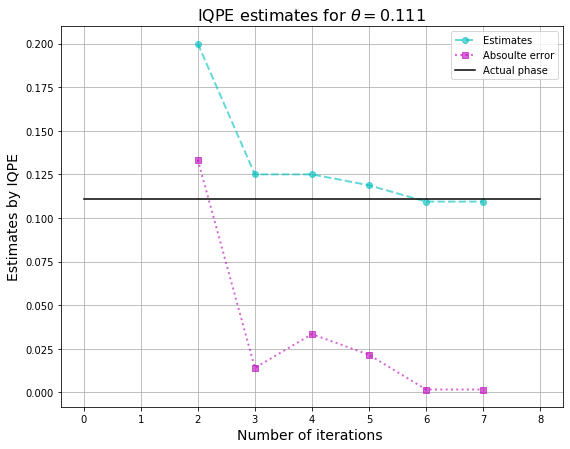

In [127]:
get_estimate_plot_phase(0.111, iters= 8, unknown=True, save=True,experiments=5)